In [10]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
app = pd.read_csv('../data/application_train.csv')

Random under-sampling:
0    24825
1    24825
Name: TARGET, dtype: int64


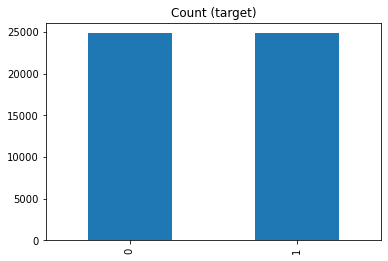

In [3]:
count_class_0, count_class_1 = app.TARGET.value_counts()
df_class_0 = app[app['TARGET'] == 0]
df_class_1 = app[app['TARGET'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
app = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(app.TARGET.value_counts())

app.TARGET.value_counts().plot(kind='bar', title='Count (target)');

In [4]:
POS_CASH_balance =  pd.read_csv('../data/POS_CASH_balance.csv')
installments_payments =  pd.read_csv('../data/installments_payments.csv')
installments_payments['MONTHS_BALANCE'] = (installments_payments['DAYS_INSTALMENT']/30).round().astype(int)

bure = pd.read_csv('../data/bureau.csv')
bure_b = pd.read_csv('../data/bureau_balance.csv')

In [5]:
df = pd.merge(app,POS_CASH_balance, how='left')
df = pd.merge(df,installments_payments, how='left')
df = pd.merge(df,bure, how='left')
df = pd.merge(df,bure_b, how='left')

/home/mateus/anaconda3/envs/home-credit/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
df.MONTHS_BALANCE = df.MONTHS_BALANCE.fillna(0).astype(int)


In [2]:
# df.to_csv('../treated_data/df_merged.csv')
df = pd.read_csv('../treated_data/df_merged.csv', index_col=0)

/home/mateus/anaconda3/envs/home-credit/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [21]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,319752,0,Cash loans,M,Y,N,0,157500.0,450000.0,30204.0,...,0.0,Active,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,319752,0,Cash loans,M,Y,N,0,157500.0,450000.0,30204.0,...,0.0,Active,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,319752,0,Cash loans,M,Y,N,0,157500.0,450000.0,30204.0,...,4.0,Active,0.0,0.0,1.0,3.0,-2571.0,-2579.0,4256.55,4256.55
3,319752,0,Cash loans,M,Y,N,0,157500.0,450000.0,30204.0,...,0.0,Active,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,319752,0,Cash loans,M,Y,N,0,157500.0,450000.0,30204.0,...,0.0,Active,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


## Separate static and continuous

In [9]:
is_static = dict((col,True) for col in df.columns)


for sk in df['SK_ID_CURR'].unique():
    df_sliced = df[df['SK_ID_CURR']==sk]
    for col in df.columns[1:]:
        x = len(df_sliced[col].unique())
        if x >1:
            is_static[col] = False

In [11]:
static=[ k for k, v in is_static.items() if v == True ]
continuous =[ k for k, v in is_static.items() if v == False ]

In [12]:
type_of_feature ={'static': static, 'continuous': continuous}

In [3]:
# with open('../treated_data/type_of_feature.json', 'w') as fp:
#     json.dump(type_of_feature, fp)
    
with open('../treated_data/type_of_feature.json', 'r') as fp:
    type_of_feature = json.load(fp)

## select most important continuous features


In [41]:
cont_app_curr = type_of_feature['continuous']+['SK_ID_CURR']

df_cont_filled = pd.get_dummies(df[cont_app_curr]).fillna(df[type_of_feature['continuous']].mean())

dfconti_pivot = df_cont_filled.pivot_table(values=list(set(df_cont_filled.columns)-set(['SK_ID_PREV', 'MONTHS_BALANCE','SK_ID_CURR'])), index='SK_ID_CURR', columns='MONTHS_BALANCE')
dfconti_pivot = dfconti_pivot.fillna(0).transpose()
# (df[type_of_feature['static']].isna().sum()/df.shape[0]).sort_values(ascending=False).head(50)
# df_grouped.corr()['TARGET'].abs().sort_values(ascending=False)>0.05
X = dfconti_pivot.values.reshape((19,97,49650))
y=df.groupby('SK_ID_CURR').median()['TARGET']

In [10]:
features = []
for i in dfconti_pivot.columns:
    features.append(i[0])
    

In [11]:
len(set(features))

19

In [5]:
df_grouped = pd.get_dummies(df[type_of_feature['static']]).groupby('SK_ID_CURR').median()
# df_grouped = pd.get_dummies(df[type_of_feature['static']]).set_index('SK_ID_CURR')

df_grouped = df_grouped[df_grouped.columns[df_grouped.isnull().mean() < 0.3]]
df_grouped = df_grouped[df_grouped.corr().abs()['TARGET'].sort_values(ascending=False)[:16].index]
df_grouped = df_grouped.fillna(df_grouped.median())

In [6]:
df_grouped 

,TARGET,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,DAYS_LAST_PHONE_CHANGE,CODE_GENDER_M,CODE_GENDER_F,DAYS_ID_PUBLISH,NAME_INCOME_TYPE_Pensioner,ORGANIZATION_TYPE_XNA,FLAG_EMP_PHONE,DAYS_EMPLOYED
SK_ID_CURR,,,,,,,,,,,,,,,,
100002,1,0.139376,0.262949,-9461,2,2,1,0,-1134.0,1,0,-2120,0,0,1,-637
100006,0,0.470456,0.650442,-19005,2,2,1,0,-617.0,0,1,-2437,0,0,1,-3039
100011,0,0.751724,0.205747,-20099,2,2,0,0,0.0,0,1,-3514,1,1,0,365243
100018,0,0.470456,0.642656,-14583,1,2,1,0,-188.0,0,1,-2056,0,0,1,-203
100031,1,0.190706,0.548477,-18724,2,3,1,0,-161.0,0,1,-1827,0,0,1,-2628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456229,0,0.865896,0.702403,-11973,2,2,1,0,-336.0,0,1,-626,0,0,1,-670
456233,1,0.397946,0.615261,-16471,2,2,0,0,-307.0,0,1,-9,0,0,1,-286
456236,0,0.365617,0.599173,-20965,2,2,1,0,0.0,1,0,-4410,0,0,1,-1618


In [7]:
X, y = df_grouped.values[:, 1:], df_grouped.values[:, 0]

In [17]:
y=df_grouped.values[:, 0]

NameError: name 'df_grouped' is not defined

In [60]:
# scaler = MinMaxScaler()
# x_static = scaler.fit_transform(X)

# Linear model

In [14]:
reg = LinearRegression().fit(X_train,y_train)

In [12]:
reg.fit(X_train,y_train)

LinearRegression()

In [16]:
reg.score(X_train,y_train)

0.15880958890441144

In [15]:
reg.score(X_test,y_test)

0.15527525241064855

# Model

In [42]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import matplotlib.pyplot as plt


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [29]:
# model = Sequential()
# model.add(N(4, input_shape=(1, look_back)))
# model.add(LSTM(4, input_shape=(1, look_back)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)


# model = keras.Sequential(
#     [
#         layers.LayerNormalization(axis = 1),
#         layers.LSTM(200, activation="relu"),
#         layers.Dense(150, activation="relu"),
#         layers.Dense(100, activation="relu"),
#         layers.Dense(20, activation="relu"),
#         layers.Dense(1, activation='sigmoid'),
#     ]
# )

model = tf.keras.Sequential([
    tf.keras.layers.LayerNormalization(axis=[1]),
    tf.keras.layers.LSTM(42, return_sequences = True),
    tf.keras.layers.LSTM(20, return_sequences = False),
    tf.keras.layers.Dense(1)
])






model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [26]:
layer = tf.keras.layers.LayerNormalization(axis=1)

In [33]:

model = keras.Sequential(
    [
        layers.Input(shape = (X.shape[1],)),
        layers.Dense(200, activation="relu"),
        layers.Dense(150, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(20, activation="relu"),
        layers.Dense(1, activation='sigmoid'),
    ]
)

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [33]:
history = model.fit(x=X_train, y=y_train, epochs= 80, batch_size=500, validation_data=(X_test,y_test) )

Epoch 1/80
67/67 [==============================] - 4s 66ms/step - loss: 0.6856 - accuracy: 0.5491 - val_loss: 0.6922 - val_accuracy: 0.5392
Epoch 2/80
67/67 [==============================] - 4s 65ms/step - loss: 0.6853 - accuracy: 0.5472 - val_loss: 0.6934 - val_accuracy: 0.5346
Epoch 3/80
67/67 [==============================] - 4s 65ms/step - loss: 0.6854 - accuracy: 0.5493 - val_loss: 0.6950 - val_accuracy: 0.5358
Epoch 4/80
67/67 [==============================] - 5s 70ms/step - loss: 0.6850 - accuracy: 0.5480 - val_loss: 0.6936 - val_accuracy: 0.5291
Epoch 5/80
67/67 [==============================] - 5s 78ms/step - loss: 0.6849 - accuracy: 0.5515 - val_loss: 0.6936 - val_accuracy: 0.5321
Epoch 6/80
67/67 [==============================] - 5s 76ms/step - loss: 0.6848 - accuracy: 0.5509 - val_loss: 0.6978 - val_accuracy: 0.5276
Epoch 7/80
67/67 [==============================] - 5s 79ms/step - loss: 0.6847 - accuracy: 0.5477 - val_loss: 0.6967 - val_accuracy: 0.5282
Epoch 8/80
67

Epoch 59/80
67/67 [==============================] - 6s 83ms/step - loss: 0.6665 - accuracy: 0.5925 - val_loss: 0.7032 - val_accuracy: 0.5393
Epoch 60/80
67/67 [==============================] - 6s 95ms/step - loss: 0.6633 - accuracy: 0.5981 - val_loss: 0.7166 - val_accuracy: 0.5400
Epoch 61/80
67/67 [==============================] - 7s 100ms/step - loss: 0.6614 - accuracy: 0.5985 - val_loss: 0.7141 - val_accuracy: 0.5332
Epoch 62/80
67/67 [==============================] - 7s 101ms/step - loss: 0.6611 - accuracy: 0.5998 - val_loss: 0.7142 - val_accuracy: 0.5412
Epoch 63/80
67/67 [==============================] - 7s 98ms/step - loss: 0.6596 - accuracy: 0.6022 - val_loss: 0.7251 - val_accuracy: 0.5344
Epoch 64/80
67/67 [==============================] - 7s 101ms/step - loss: 0.6590 - accuracy: 0.6026 - val_loss: 0.7175 - val_accuracy: 0.5387
Epoch 65/80
67/67 [==============================] - 7s 101ms/step - loss: 0.6605 - accuracy: 0.6011 - val_loss: 0.7206 - val_accuracy: 0.5326
Ep

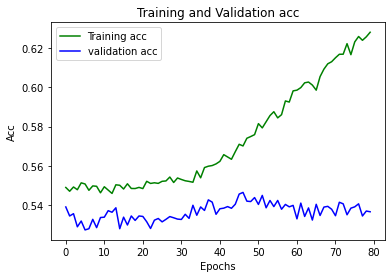

In [34]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(80)
plt.plot(epochs, loss_train, 'g', label='Training acc')
plt.plot(epochs, loss_val, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()